# 3.8 커스텀 도구(tool)를 최대한 활용하는 방법

In [1]:
from dotenv import load_dotenv

load_dotenv(dotenv_path="../.env")

True

In [2]:
from langgraph.graph import StateGraph, MessagesState
from langchain_ollama import ChatOllama

query = "5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?"
llm = ChatOllama(model="llama3.1")
workflow = StateGraph(MessagesState)

c:\Users\limjangmook\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma

collection_name = "real_estate_tax"
embedding_function = HuggingFaceEmbeddings(model="BAAI/bge-m3")
vector_store = Chroma(
    collection_name=collection_name,
    embedding_function=embedding_function,
    persist_directory="./chroma"
)
retriever = vector_store.as_retriever(search_kwargs={"k": 3})
response = retriever.invoke(query)
response

[Document(id='8497fa3a-dd13-4b29-bdef-78ee7945951f', metadata={'producer': 'iText 2.1.7 by 1T3XT', 'creationdate': '2025-12-14T19:22:42+09:00', 'page_label': '4', 'creator': 'PyPDF', 'source': './documents/real_estate_tax.pdf', 'moddate': '2025-12-14T19:22:42+09:00', 'total_pages': 10, 'page': 3}, page_content='법제처                                                            4                                                       국가법령정보센터\n종합부동산세법\n1. 「상속세 및 증여세법」 제16조에 따른 공익법인등(이하 이 조에서 “공익법인등”이라 한다)이 직접 공익목적사업\n에 사용하는 주택만을 보유한 경우와 「공공주택 특별법」 제4조에 따른 공공주택사업자 등 사업의 특성을 고려하\n여 대통령령으로 정하는 경우: 제1항제1호에 따른 세율\n2. 공익법인등으로서 제1호에 해당하지 아니하는 경우: 제1항 각 호에 따른 세율\n3. 제1호 및 제2호 외의 경우: 다음 각 목에 따른 세율\n가. 2주택 이하를 소유한 경우: 1천분의 27\n나. 3주택 이상을 소유한 경우: 1천분의 50\n③주택분 과세표준 금액에 대하여 해당 과세대상 주택의 주택분 재산세로 부과된 세액(「지방세법」 제111조제3항\n에 따라 가감조정된 세율이 적용된 경우에는 그 세율이 적용된 세액, 같은 법 제122조에 따라 세부담 상한을 적용받\n은 경우에는 그 상한을 적용받은 세액을 말한다)은 주택분 종합부동산세액에서 이를 공제한다.<신설 2005. 12. 31.,\n2008. 12. 26., 2010. 3. 31.>\n④주택분 종합부동산세액을 계산할 때 주택

In [4]:
# print(response[0].page_content)

- [rlm/rag-prompt](https://smith.langchain.com/hub/rlm/rag-prompt)
- HUMAN
    - You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
    - Question: {question} 
    - Context: {context} 
- Answer:

In [5]:
from langchain_classic import hub

rag_prompt = hub.pull("rlm/rag-prompt")

def format_docs(docs):
    """
    여러 문서를 하나의 문자열로 결합하는 포맷팅 함수
    Args:
        docs: page_content를 포함하는 Document 객체 리스트
    Returns:
        str: 줄바꿈으로 구분된 문서 내용을 하나로 합친 문자열
    """
    return "\n\n".join(doc.page_content for doc in docs)

```python
tools = [get_tax_equation, get_tax_deduction, get_market_ratio, calculate_tax]
```

In [6]:
from langchain_core.tools import tool
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

@tool
def get_tax_equation() -> str:
    """종합부동산세 과세표준을 계산하기 위한 공식을 검색하고 형식화합니다.
    이 도구는 RAG(Retrieval Augmented Generation) 방식을 사용하여:
    1. 지식 베이스에서 과세표준 계산 규칙을 검색
    2. 검색한 규칙을 수학 공식으로 형식화
    Args:
        question (str): 사용자의 질문 (미리 정의된 질문이 사용됨)
    Returns:
        str: 과세표준 계산 공식
    """
    print("**** get_tax_equation ****")

    tax_equation_question = "주택에 대한 종합부동산세 과세표준을 계산하는 방법은 무엇인가요? 수식으로 표현해서 수식만 반환해주세요"
    tax_equation_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | rag_prompt
        | llm
        | StrOutputParser()
    )
    tax_equation = tax_equation_chain.invoke(tax_equation_question)
    return tax_equation

In [7]:
from langchain_core.prompts import PromptTemplate

@tool
def get_tax_deduction(question: str) -> str:
    """사용자의 부동산 소유 현황에 대한 질문을 기반으로 세금 공제액을 계산합니다.
    이 도구는 다음 두 단계로 작동합니다:
    1. tax_deductible_chain을 사용하여 일반적인 세금 공제 규칙을 검색
    2. user_deduction_chain을 사용하여 사용자의 특정 상황에 규칙을 적용
    Args:
        question (str): 부동산 소유에 대한 사용자의 질문
    Returns:
        str: 세금 공제액 (예: '9억원', '12억원')
    """
    print("**** get_tax_deduction ****")

    tax_deduction_question = "주택에 대한 종합부동산세 과세표준의 공제액을 알려주세요"
    tax_deduction_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | rag_prompt
        | llm
        | StrOutputParser()
    )
    tax_deduction_response = tax_deduction_chain.invoke(tax_deduction_question)

    user_deduction_template = """아래 [Context]는 주택에 대한 종합부동산세의 공제액에 관한 내용입니다. 
        사용자의 질문을 통해서 가지고 있는 주택수에 대한 공제액이 얼마인지 설명없이 금액만 반환해주세요
        [Context]: {tax_deduction_response}
        [Question]: {question}
        [Answer]: """
    user_deduction_prompt = PromptTemplate(
        template=user_deduction_template,
        input_variables=["tax_deduction_response", "question"],
    )
    user_deduction_chain = (
        user_deduction_prompt
        | llm
        | StrOutputParser()
    )
    user_deduction_response = user_deduction_chain.invoke({
        "tax_deduction_response": tax_deduction_response,
        "question": question,
    })
    return user_deduction_response

In [8]:
# query = "5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?""

# get_tax_deduction.invoke(query)

In [9]:
from langchain_community.tools import DuckDuckGoSearchRun
from datetime import datetime

def get_market_ratio_research():
    """
    현재 연도의 공정시장가액비율을 웹에서 검색합니다.
    Returns:
        str: 현재 공정시장가액비율 정보를 포함한 검색 결과
    """
    search = DuckDuckGoSearchRun()
    return search.invoke(f"{datetime.now().year}년도 공정시장가액비율은?")
    
@tool
def get_market_ratio(question: str) -> str:
    """사용자의 부동산 상황에 적용되는 공정시장가액비율을 결정합니다.
    이 도구는:
    1. 현재 공정시장가액비율 정보가 포함된 검색 결과를 사용
    2. 사용자의 특정 상황(보유 부동산 수, 부동산 가치)을 분석
    3. 적절한 공정시장가액비율을 백분율로 반환
    Args:
        question (str): 부동산 소유에 대한 사용자의 질문
    Returns:
        str: 공정시장가액비율 백분율 (예: '60%', '45%')
    """
    print("**** get_market_ratio ****")

    market_ratio_template = """아래 [Context]는 공정시장가액비율에 관한 내용입니다.
        당신에게 주어진 공정시장가액비율에 관한 내용을 기반으로, 사용자의 상황에 대한 공정시장가액비율을 알려주세요.
        별도의 설명 없이 공정시장가액비율만 반환해주세요.
        [Context]: {context}
        [Question]: {question}
        [Answer]: """
    market_ratio_prompt = PromptTemplate(
        template=market_ratio_template,
        input_variables=["context", "question"]
    )
    market_ratio_chain = (
        market_ratio_prompt
        | llm
        | StrOutputParser()
    )
    market_ratio = market_ratio_chain.invoke({
        "context": get_market_ratio_research(),
        "question": question,
    })
    return market_ratio

In [10]:
# query = "5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?""

# get_market_ratio.invoke(query)

In [11]:
from langchain_core.prompts import ChatPromptTemplate

@tool
def calculate_tax(tax_equation: str, tax_deduction: str, market_ratio: str, question: str) -> str:
    """수집된 모든 정보를 사용하여 최종 종합부동산세액을 계산합니다.
    이 도구는 다음 정보들을 결합하여 최종 세액을 계산합니다:
    1. 과세표준 계산 방법
    2. 공제액
    3. 공정시장가액비율
    4. 세율표
    Args:
        tax_equation (str): 과세표준 계산 방법
        tax_deduction (str): 공제액
        market_ratio (str): 공정시장가액비율
        question (str): 부동산 세금 계산에 대한 사용자의 질문
    Returns:
        str: 설명이 포함된 최종 세금 계산액
    """
    print("**** calculate_tax ****")

    system_messages = f"""
        과세표준 계산 방법: {tax_equation}
        공제액: {tax_deduction}
        공정시장가액비율: {market_ratio}
        위의 공식과 아래 세율에 관한 정보를 활용해서 세금을 계산해 주세요.
        세율: {{tax_rate}} """
    tax_prompt = ChatPromptTemplate.from_messages([
        ("system", system_messages),
        ("human", "{question}")
    ])
    tax_chain = (
        {"tax_rate": retriever | format_docs, "question": RunnablePassthrough()}
        | tax_prompt
        | llm
        | StrOutputParser()
    )
    tax = tax_chain.invoke(question)
    return tax

In [12]:
from langgraph.prebuilt import ToolNode

tools = [get_tax_equation, get_tax_deduction, get_market_ratio, calculate_tax]
tool_node = ToolNode(tools=tools)

llm_with_tools = llm.bind_tools(tools=tools)

In [13]:
from langchain_core.messages import SystemMessage

def agent(state: MessagesState) -> MessagesState:
    """
    에이전트 함수는 주어진 상태에서 메시지를 가져와 LLM과 도구를 사용하여 응답 메시지를 생성합니다.
    Args:
        state (MessagesState): 메시지 상태를 포함하는 state.
    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    """
    print("**** agent ****")

    system_message = """당신의 역할은 주택에 대한 종합부동산세를 계산하는 것입니다. 
        사용자의 질문이 들어오면, 사용자의 질문을 바탕으로 종합부동산세를 계산해주세요.
        종합부동산세를 계산하기 위해서는 과세표준을 어떻게 계산할지 파악해야하고, 
        사용자에 질문에 따른 공제액을 파악해야 하고, 
        사용자에 질문에 따른 공정시장가액비율을 파악해야 합니다.
        이 세가지를 파악하고 나면, 종합부동산세를 계산해주세요."""
    messages = [SystemMessage(content=system_message)] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [14]:
from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition

workflow.add_node(agent)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", tools_condition)
workflow.add_edge("tools", "agent")

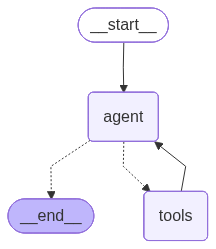

In [15]:
graph = workflow.compile()
graph

In [16]:
from langchain_core.messages import HumanMessage

# query = "5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?"

for response in graph.stream({"messages": [HumanMessage(query)]}, stream_mode="values"):
    response["messages"][-1].pretty_print()

================================ Human Message =================================

5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?
**** agent ****
================================== Ai Message ==================================
Tool Calls:
  calculate_tax (668bed42-9ae1-4eeb-b6ec-a11c3b91d66e)
 Call ID: 668bed42-9ae1-4eeb-b6ec-a11c3b91d66e
  Args:
    market_ratio: get_market_ratio
    question: 5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?
    tax_deduction: get_tax_deduction
    tax_equation: get_tax_equation
**** calculate_tax ****
================================= Tool Message =================================
Name: calculate_tax

주택분 종합부동산세법에 따르면, 납세의무자가 소유한 주택 수에 따라 과세표준에 해당 세율을 적용하여 계산합니다.

일단, 주택분 종합부동산세를 계산하기 위한 과세표준은 총 35억입니다. (5억 + 10억 + 20억)

그 다음, 납세의무자의 주택 수에 따라 과세표준에 해당 세율을 적용합니다.

*   납세의무자가 2주택 이하를 소유한 경우: 세율은 1천분의 27입니다.
*   납세의무자가 3주택 이상을 소유한 경우: 세율은 1천분의 50입니다.

우리는 5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있으므로, 우리가 소유한 주택 수는 3개입니다. 따라서, 우리에게 적용될 세율